<a href="https://colab.research.google.com/github/alibekk93/GK_evaluation/blob/main/GK_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [315]:
# essential ones
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [316]:
!pip install requests_html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [317]:
import requests
from requests_html import HTMLSession
from bs4 import BeautifulSoup

In [318]:
def convert_age(str_age:str) -> float:
  """Converts age of FBRef format into float, e.g. '12-345' to 12.945
  """

  years, days = (float(s) for s in str_age.split('-'))
  days /= 365
  return years + days

In [319]:
session = HTMLSession()

In [434]:
# get html
r = session.get('https://fbref.com/en/comps/Big5/keepersadv/players/Big-5-European-Leagues-Stats')
soup = BeautifulSoup(r.html.raw_html)
# find table and process data into dataframe
table = soup.findAll('table')[0]
headers = table.find('thead').findAll('tr')[1].text.split('\n')[2:-1]
rows = table.find('tbody').findAll('tr')
data = [r.findAll('td') for r in rows]
data = pd.DataFrame(np.array([row[col].text for row in data for col in range(len(row))]).reshape(-1, 34), columns=headers)
# renaming some columns for better aestetics
data.columns = ['Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age', 'Born', 'Played90s', 'GA',
                'PKA', 'FK', 'CK', 'OG', 'PSxG', 'PSxG_perSoT', 'PSxG_diff', 'PSxG_diff_per90', 'Cmp',
                'Att', 'Cmp_p', 'PassAtt', 'PassThr', 'PassLaunch_p', 'PassAvgLen', 'GKAtt', 'GKLaunch_p',
                'GKAvgLen', 'CrossAtt', 'CrossStp', 'CrossStp%', 'nOPA', 'nOPA_per90', 'AvgDistOPA', 'Matches']
# convert data
data.Age = data.Age.apply(convert_age)
NUMERIC = ['Age', 'Born', 'Played90s', 'GA', 'PKA', 'FK', 'CK', 'OG', 'PSxG', 'PSxG_perSoT', 'PSxG_diff',
           'PSxG_diff_per90', 'Cmp', 'Att', 'Cmp_p', 'PassAtt', 'PassThr', 'PassLaunch_p', 'PassAvgLen',
           'GKAtt', 'GKLaunch_p', 'GKAvgLen', 'CrossAtt', 'CrossStp', 'CrossStp%', 'nOPA', 'nOPA_per90', 'AvgDistOPA']
for col in NUMERIC:
  data[col] = pd.to_numeric(data[col], errors='coerce')

DIVISIBLES = ['Cmp', 'Att', 'PassAtt', 'PassThr', 'GKAtt', 'CrossAtt', 'CrossStp']
for col in DIVISIBLES:
  colName = col + '_per90'
  data[colName] = data[col] / data.Played90s

NUMERIC += [colName + '_per90' for colName in DIVISIBLES]

In [448]:
data_filtered = data[data.Played90s >= 10]
data_filtered = data_filtered.dropna()

In [449]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

PCA_COLUMNS = ['PSxG_diff_per90', 'PassAtt_per90', 'PassThr_per90', 'PassLaunch_p', 'PassAvgLen',
               'CrossAtt_per90', 'CrossStp_per90', 'nOPA_per90', 'AvgDistOPA']

pipeline = Pipeline([('scaler', StandardScaler()), ('model_pca', PCA(n_components=2))])

X = data_filtered[PCA_COLUMNS]

data_transformed = pd.DataFrame(pipeline.fit_transform(X))

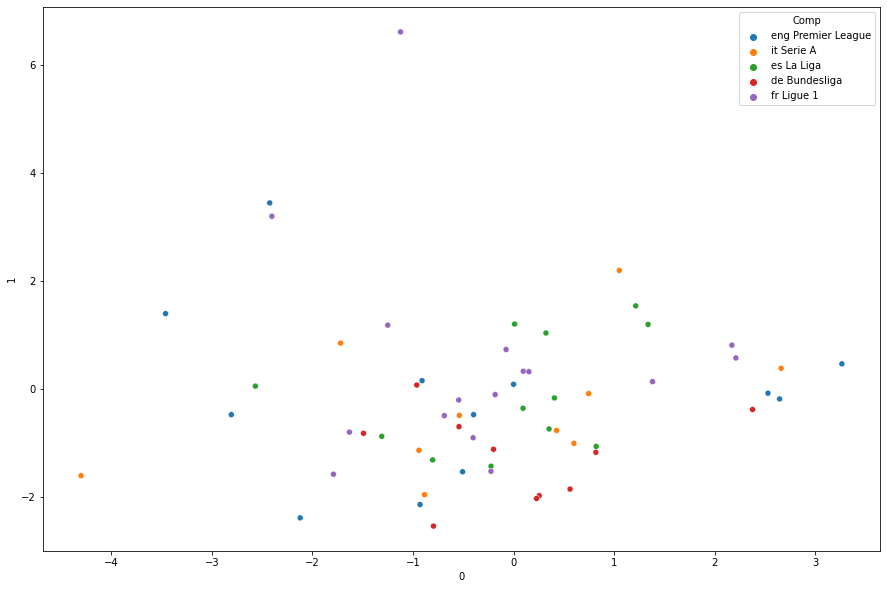

In [450]:
fig, ax = plt.subplots(figsize=(15,10))
sns.scatterplot(x=data_transformed[0], y=data_transformed[1], hue=data_filtered.Comp)

In [451]:
inverse = pd.DataFrame(pipeline.inverse_transform([[10, 10], [-10, 10], [10, -10], [-10, -10]]), columns=PCA_COLUMNS)

In [452]:
inverse

,PSxG_diff_per90,PassAtt_per90,PassThr_per90,PassLaunch_p,PassAvgLen,CrossAtt_per90,CrossStp_per90,nOPA_per90,AvgDistOPA
0,0.414379,53.361393,5.677101,6.146905,22.726186,1.435053,0.356155,5.733110,36.967831
1,-0.767565,22.316242,0.084996,130.456885,71.767251,16.993127,0.609562,3.611185,23.918292
2,0.696545,33.256796,9.298155,-59.211987,-3.683578,9.765336,0.940738,-1.294246,5.632728
3,-0.485399,2.211646,3.706050,65.097993,45.357487,25.323410,1.194145,-3.416171,-7.416811


In [459]:
data_filtered.loc[data_transformed[data_transformed[0]<-4].index]

,Player,Nation,Pos,Squad,Comp,Age,Born,Played90s,GA,PKA,...,nOPA_per90,AvgDistOPA,Matches,Cmp_per90,Att_per90,PassAtt_per90,PassThr_per90,GKAtt_per90,CrossAtt_per90,CrossStp_per90
40,Wladimiro Falcone,it ITA,GK,Lecce,it Serie A,27.794521,1995,19.0,22.0,3.0,...,1.0,12.2,Matches,5.052632,19.526316,24.421053,3.842105,7.947368,15.368421,0.684211


In [446]:
data_filtered

,Player,Nation,Pos,Squad,Comp,Age,Born,Played90s,GA,PKA,...,nOPA_per90,AvgDistOPA,Matches,Cmp_per90,Att_per90,PassAtt_per90,PassThr_per90,GKAtt_per90,CrossAtt_per90,CrossStp_per90
0,Doğan Alemdar,tr TUR,GK,Rennes,fr Ligue 1,20.246575,2002,2.5,4.0,0.0,...,1.20,13.1,Matches,5.600000,13.600000,20.800000,1.600000,7.600000,16.000000,0.800000
1,Alisson,br BRA,GK,Liverpool,eng Premier League,30.320548,1992,19.0,25.0,2.0,...,2.00,19.5,Matches,3.157895,7.315789,31.789474,6.473684,5.315789,11.315789,0.421053
2,Alphonse Areola,fr FRA,GK,West Ham,eng Premier League,29.915068,1993,1.2,2.0,1.0,...,0.84,14.3,Matches,7.500000,16.666667,25.833333,2.500000,8.333333,12.500000,0.000000
3,Kepa Arrizabalaga,es ESP,GK,Chelsea,eng Premier League,28.317808,1994,11.5,9.0,0.0,...,2.17,17.6,Matches,2.521739,7.826087,29.913043,5.043478,7.217391,14.521739,0.695652
4,Sergio Asenjo,es ESP,GK,Valladolid,es La Liga,33.583562,1989,5.0,7.0,0.0,...,2.60,18.9,Matches,5.800000,16.400000,26.400000,3.200000,9.800000,15.400000,0.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,Danny Ward,wls WAL,GK,Leicester City,eng Premier League,29.600000,1993,20.0,35.0,2.0,...,1.75,16.0,Matches,3.500000,11.400000,29.400000,6.600000,7.700000,14.150000,0.850000
153,Robin Zentner,de GER,GK,Mainz 05,de Bundesliga,28.249315,1994,15.0,24.0,0.0,...,2.07,18.1,Matches,5.733333,19.066667,24.466667,5.333333,7.333333,11.533333,1.533333
154,Michael Zetterer,de GER,GK,Werder Bremen,de Bundesliga,27.545205,1995,0.7,1.0,0.0,...,5.81,16.5,Matches,10.000000,24.285714,41.428571,11.428571,4.285714,8.571429,4.285714
155,Jeroen Zoet,nl NED,GK,Spezia,it Serie A,32.057534,1991,1.7,1.0,0.0,...,1.74,15.7,Matches,8.823529,25.294118,33.529412,2.941176,4.705882,14.117647,0.588235
